In [ ]:
import json

import numpy as np
import pandas as pd
import pymongo
import scipy
from bson import ObjectId, json_util
from pandas.io.json import json_normalize
from pymongo import MongoClient as Connection
from scipy import sparse, spatial
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# scientific notation disabled form smaller numbers
pd.options.display.float_format = '{:.5f}'.format

# alles resultate anzeigen und nicht nur das letzte
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [ ]:
connection = Connection()
db = connection.recipe_db
input_data = db.recipes_without_reviews

data = json.loads(json_util.dumps(input_data.find()))

In [ ]:
ing = pd.DataFrame(json_normalize(data, record_path='ingredients',
                             meta='id', record_prefix='ingredients_', errors='ignore'))


nutritions = pd.DataFrame(json_normalize(data, record_path='nutritions',
                            meta=['id', 'prep_time', 'rating', 'rating_count', 'ready_in_time', 'review_count']))


In [ ]:
#  ------  erstellung und data cleansing - Ingredients

# schmeiss alle zutaten raus, die weniger als 5 mal verwendet werden
# setze multiinde auf 'id' und 'ingredients_id'
ingredients = ing.set_index(['id', 'ingredients_id'])

# filtere alle Zutaten samt ihrer rezepte id, die weniger gleich 5 mal vorkommen
ingredients_eqles_5_ing = ingredients.groupby(
    'ingredients_id').filter(lambda x: len(x) <= 5)

# droppe alle rezepte, die eine Zutate besitzen, die weniger gleich 5 Mal vorkommen
ingredients_filt = ingredients.drop(ingredients_eqles_5_ing.index.get_level_values('id').values, level=0)

# drop alls rows with ingredients_id == 0
ingredients_eqal_zero = ingredients_filt[ingredients_filt.index.get_level_values('ingredients_id') == 0]
ingredients_filt = ingredients_filt.drop(ingredients_eqal_zero.index.get_level_values('id').values, level=0)


In [ ]:
#  ------ Erstellung und cleansing des Nutrition Dataframes

# erstelle neue liste auf basis der bereits gefilterten rezepte aus ingredients_filt
id_overlap_mask = nutritions['id'].isin(ingredients_filt.index.get_level_values('id').values)

# erstelle datenframe auf basis der overlapliste
nutritions_filt = nutritions.loc[id_overlap_mask]

nutrition_db = nutritions_filt.pivot_table(
    index=['id'],
    columns=['name'],
    values=['amount'],
).reset_index()

nutrition_db.set_index('id', inplace=True)

# remove multiindex 'amount'
nutrition_db.columns = nutrition_db.columns.droplevel(0)

# entferne alle NA
nutrition_db = nutrition_db.dropna()

# gleiche nochmals die ids der beiden dataframe nutrition und ingredients ab, da der nutrition dataframe noch NA Werte hatt
id_overlap_mask = ingredients_filt.index.get_level_values('id').isin(nutrition_db.index)
ingredients_db = ingredients_filt[id_overlap_mask]

# abgleich ob anzahl der indizes von nutrition und zutaten dataframe gleich sind


In [ ]:
ingredients_db.reset_index(inplace=True)

recipe_db = pd.get_dummies(ingredients_db['ingredients_id']).groupby(
    ingredients_db['id']).apply(max)



In [ ]:
new_ingredients = ingredients_db.copy()
#new_ingredients = new_ingredients.groupby("id")["ingredients_grams"].sum().reset_index()
gramms_ingredients = new_ingredients.groupby("id")["ingredients_grams"].sum().reset_index().copy()

Q1 = gramms_ingredients.quantile(0.25)
Q3 = gramms_ingredients.quantile(0.75)
IQR = Q3 - Q1

#Filter out all recipes which are outlier by their weight (gramms)
df = gramms_ingredients[~((gramms_ingredients < (Q1 - 1.5 * IQR)) |(gramms_ingredients > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

#filter out recipes by weight which are not in the range 500 - 2373.59 gramms
df_start_at_fivehundret = df[df['ingredients_grams'].between(500, 2373.58225, inclusive=False)].copy()

df_start_at_fivehundret.set_index('id', inplace=True)
id_overlap_mask = nutritions['id'].isin(df_start_at_fivehundret.index.get_level_values('id').values)


# erstelle datenframe auf basis der overlapliste
nutritions_filt_gramm = nutritions.loc[id_overlap_mask]

nutrition_db2 = nutritions_filt_gramm.pivot_table(
    index=['id'],
    columns=['name'],
    values=['amount'],
).reset_index()

#create new nutrition db based on the above filtering
nutrition_db2.set_index('id', inplace=True)
nutrition_db2.columns = nutrition_db2.columns.droplevel(0)



In [ ]:
# remove recipes which are missing in nutrition df from the ingredients tecipes dataframe
mask = recipe_db.index.isin(nutrition_db2.index.values)
recipe_db = recipe_db.loc[mask]


In [ ]:
#top10 most common ingredients
#16421    2125 salt
#4342     1506 garlic
#4397     1412 onion
#16406    1185 ground black pepper
#16157    1016 butter
#6307      944 olive oil
#6494      786 skinless bone less chicken breast
#2496      749 water
#16238     574 grated Parmesan cheese
#16317     538 eggs
drop_id_list = [16421, 4342, 4397, 16406, 16157, 6307, 6494, 2496, 16238, 16317]


#filter out ingredients which are too common and the recipes in the user profile from the recipes database
recipe_db = recipe_db.drop(axis=1, labels=drop_id_list)


In [ ]:
result_array = cdist(recipe_db, recipe_db,'jaccard')
distance_jacc = pd.DataFrame(result_array, columns=recipe_db.index.values, index=recipe_db.index.values)

In [ ]:
ingredients_db.loc[ingredients_db['ingredients_id'] == 16421]

In [ ]:
ingredients_db_no_dupes = ingredients_db.drop_duplicates(subset=['ingredients_id'])

del ingredients_db_no_dupes['id']
del ingredients_db_no_dupes['ingredients_grams']
del ingredients_db_no_dupes['ingredients_type']

ingredients_db_no_dupes.set_index('ingredients_id', inplace=True)

ing_count = ingredients_db['ingredients_id'].value_counts()
ing_count = pd.DataFrame(ing_count) 
ing_count.rename(columns={ing_count.columns[0]:'ing_count'}, inplace=True)

ingredients_db_no_dupes = ingredients_db_no_dupes.join(ing_count)
ingredients_db_no_dupes = ingredients_db_no_dupes.sort_values('ing_count', ascending=False)

In [ ]:
ingredients_db_no_dupes[0:10]

In [ ]:
 ingredients_db_no_dupes.ingredients_name.str.contains(r'chicken').sum()

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = 0.4, min_samples = 5, metric='precomputed' ).fit(distance_jacc) 
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

In [ ]:
cluster_dbscan = db.labels_
cluster_dbscan = pd.DataFrame(cluster_dbscan, index=recipe_db.index.values)
cluster_dbscan.rename(columns={cluster_dbscan.columns[0]:'cluster'}, inplace=True)
cluster_dbscan.groupby(['cluster']).size()

In [ ]:
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt



dists = squareform(distance_jacc)
#linkage_matrix = linkage(dists, "single")
#dendrogram(linkage_matrix)
plt.title("test")
#plt.show()

In [ ]:
dists = squareform(distance_jacc)

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
  
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 


pca = PCA(n_components = 2) 
result_array = cdist(recipe_db, recipe_db,'jaccard')
X_principal = pca.fit_transform(result_array) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 



In [ ]:

db_default = DBSCAN(eps = 0.12, min_samples = 29).fit(X_principal) 
labels = db_default.labels_ 

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

In [ ]:
test1 = db_default.labels_
test1 = pd.DataFrame(test1, index=recipe_db.index.values)
test1.rename(columns={test1.columns[0]:'cluster'}, inplace=True)
test1.groupby(['cluster']).size()

In [ ]:
test1[(test1['cluster'] == 3)].index.to_numpy()

In [ ]:
colours1 = {} 
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[-1] = 'k'

cvec = [colours1[label] for label in labels] 
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k' ] 

r = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[0]) 
g = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[1]) 
b = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[2]) 
c = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[3]) 
y = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[4]) 
m = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[5]) 
k = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[6]) 

plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec) 
plt.legend((r, g, b, c, y, m, k), 
		('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 
			'Label 5', 'Label -1'), 
		scatterpoints = 1, 
		loc ='upper left', 
		ncol = 3, 
		fontsize = 8) 
plt.show() 


In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='precomputed')
X_test = mds.fit_transform(distance_jacc)



In [ ]:

db_default = DBSCAN(eps = 0.0375, min_samples = 20).fit(X_test) 
labels = db_default.labels_ 

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

In [ ]:
test1 = db_default.labels_
test1 = pd.DataFrame(test1, index=recipe_db.index.values)
test1.rename(columns={test1.columns[0]:'cluster'}, inplace=True)
test1.groupby(['cluster']).size()

In [ ]:
colours1 = {} 
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[-1] = 'k'

cvec = [colours1[label] for label in labels] 
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k' ] 

r = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[0]) 
g = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[1]) 
b = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[2]) 
c = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[3]) 
y = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[4]) 
m = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[5]) 
k = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[6]) 

plt.figure(figsize =(9, 9)) 
plt.scatter(X_test[:,0], X_test[:,1], c = cvec) 
plt.legend((r, g, b, c, y, m, k), 
		('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 
			'Label 5', 'Label -1'), 
		scatterpoints = 1, 
		loc ='upper left', 
		ncol = 3, 
		fontsize = 8) 
plt.show() 


In [ ]:
import scipy.cluster.hierarchy as sch

#Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and then in linkage we have to #specify on which data we apply and engage. This is X dataset

dendrogram = sch.dendrogram(sch.linkage(recipe_db, metric='euclidean', method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage ='ward')

hc.fit_predict(recipe_db)

labels = hc.labels_

In [ ]:
from sklearn.cluster import AgglomerativeClustering 
hc2 = AgglomerativeClustering(n_clusters = 5, affinity = 'precomputed', linkage ='complete')

hc2.fit_predict(distance_jacc)

labels = hc2.labels_

In [ ]:
y_hc2=hc.fit(recipe_db)

In [ ]:
bla = y_hc2.labels_

In [ ]:
bla.shape

In [ ]:
labels

In [ ]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

In [148]:
test2 = labels
test2 = pd.DataFrame(test2, index=recipe_db.index.values)
test2.rename(columns={test2.columns[0]:'cluster'}, inplace=True)
test2.groupby(['cluster']).size()

cluster
0     980
1     375
2    2132
3     141
4     142
dtype: int64

In [ ]:
test2[(test2['cluster'] == 1)].index.to_numpy()

In [ ]:
test2[(test2['cluster'] == 0)].index.to_numpy()

In [ ]:
y_hc

In [ ]:
from sklearn.manifold import MDS
result_array2 = cdist(recipe_db, recipe_db, 'euclidean')
distance_euclid = pd.DataFrame(result_array2, columns=recipe_db.index.values, index=recipe_db.index.values)




In [ ]:
result_array2

In [154]:
mds = MDS(n_components=2, dissimilarity='euclidean')
X_test = mds.fit_transform(recipe_db)


In [ ]:
X_test = mds.fit(distance_euclid)

In [ ]:
X_test.shape

In [ ]:
labels

In [ ]:
X_test[:,0]

In [ ]:

plt.figure(figsize =(10, 10)) 
plt.scatter(X_test[:,0],X_test[:,1], c=hc.labels_, cmap='Dark2')

<Figure size 648x648 with 0 Axes>

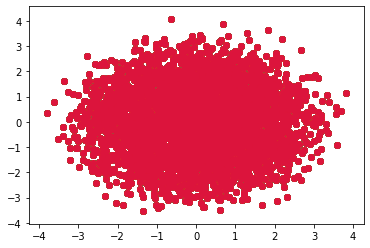

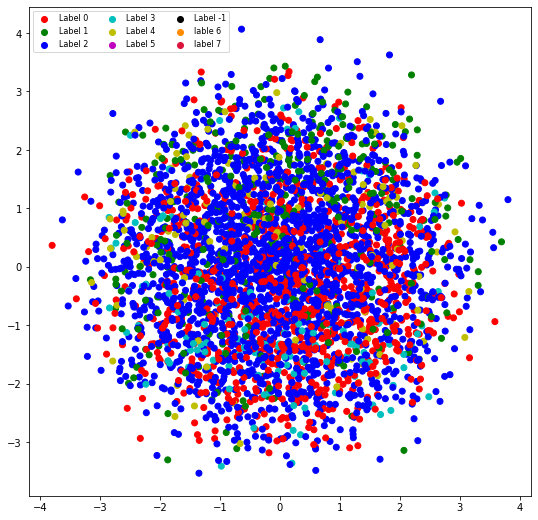

In [155]:
colours1 = {} 
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[6] = 'darkorange'
colours1[7] = 'crimson'
colours1[-1] = 'k'

cvec = [colours1[label] for label in labels] 
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k', 'darkorange', 'crimson' ] 

r = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[0]) 
g = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[1]) 
b = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[2]) 
c = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[3]) 
y = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[4]) 
m = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[5]) 
k = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[6]) 
do = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[7]) 
crim = plt.scatter( 
		X_test[:,0], X_test[:,1], marker ='o', color = colors[8]) 

plt.figure(figsize =(9, 9)) 
plt.scatter(X_test[:,0], X_test[:,1], c = cvec) 
plt.legend((r, g, b, c, y, m, k, do, crim), 
		('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 
			'Label 5', 'Label -1', 'lable 6', 'label 7'), 
		scatterpoints = 1, 
		loc ='upper left', 
		ncol = 3, 
		fontsize = 8) 
plt.show() 

In [150]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
  
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 


pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(recipe_db) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

<Figure size 648x648 with 0 Axes>

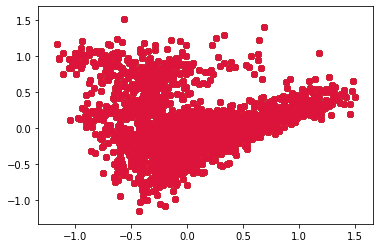

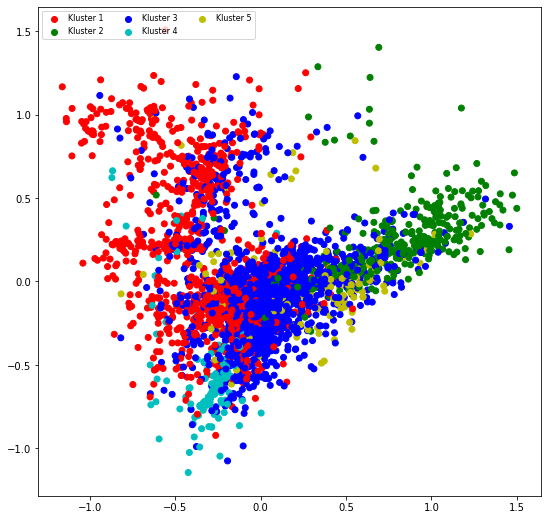

In [151]:
colours1 = {} 
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[6] = 'darkorange'
colours1[7] = 'crimson'
colours1[-1] = 'k'

cvec = [colours1[label] for label in labels] 
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k', 'darkorange', 'crimson' ] 

r = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[0]) 
g = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[1]) 
b = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[2]) 
c = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[3]) 
y = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[4]) 
m = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[5]) 
k = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[6]) 
do = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[7]) 
crim = plt.scatter( 
		X_principal['P1'], X_principal['P2'], marker ='o', color = colors[8]) 

plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec) 
plt.legend((r, g, b, c, y, m, k, do, crim), 
		( 'Kluster 1', 'Kluster 2', 'Kluster 3', 'Kluster 4', 
			'Kluster 5'), 
		scatterpoints = 1, 
		loc ='upper left', 
		ncol = 3, 
		fontsize = 8) 
plt.show() 
